To-do:
1. Текст был очищен только от одного мусорного элемента в качестве примера. Исслудйте данные через ноутбук или чере веб-интерфейс BigQuery на предмет других мусорных элементов в тексте, которые не несут в себе никакого особого смысла, а только создают шум в данных. Доработайте функцию очистки тектосвых данных, чтобы в нее можно было передать список ненужного мусора и разом выполнялась очистка
2. Проведите стратифицировнную кросс-валидуцию нейросетевого классификатора https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
3. Поэксперементируйте с гиперпараметрами нейросетевого классификатора, постарайтесь повысить качество его работы
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4. Попробуйте использовать не Word2Vec для получения векторого представления текста, а TF-IDF преобразование http://zabaykin.ru/?p=558 http://nlpx.net/archives/57
5. Попробуйте использовать более тонко настриваемые алгоритмы нейросетей, например из этого видео https://www.youtube.com/watch?v=cPkH1k3U1c8 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.oauth2 import service_account
import pandas_gbq 

import numpy as np
import pandas as pd
import math as mt
import datetime as dt

from langdetect import detect
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from gensim.models.word2vec import Word2Vec
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [2]:
#funtion for getting fresh data from DWH for workload model
"""[summary]
Funtion for getting fresh data from BigQuery for workload scoring model
[description]
Credentials - google service account object with credentials data for project
[example]
Input: Credentials = credentials_object
Output: description	                                        channel	 category	category_flag
        \nChat transcript:\nVisitor: I want to buy wit...	chat	 ps	        1
        \nChat transcript:\nVisitor: hell i had a prob...	chat	 ps	        1
        \nChat transcript:\nVisitor: لا استطيع الشراء ...	 chat	  ps	     1
"""

def getDwhData(Credentials):
    statement_bigquery_sql = " ".join(["select description, channel, case",
                                       "when manual_category in ('payment_problem','how_to_pay','howtopay','how_to_play','paystation_error','ps_problem','ps_declined') then 'ps'",
                                       "else 'other'",
                                       "end as category,",
                                       "case",
                                       "when manual_category in ('payment_problem','how_to_pay','howtopay','how_to_play','paystation_error','ps_problem','ps_declined') then 0",
                                       "else 1",
                                       "end as category_flag",
                                       "from `xsolla_summer_school.customer_support`",
                                       "where manual_category is not null and",
                                       "manual_category <> '' and",
                                       "description is not null and",
                                       "description <> '' and",
                                       "channel is not null and",
                                       "channel <> '' and",
                                       "channel in ('chat','facebook')"])
    
    dataframe_bigquery = pandas_gbq.read_gbq(statement_bigquery_sql,project_id='findcsystem', credentials=Credentials, dialect='standard')

    return dataframe_bigquery


"""[summary]
Function for transform text to lower case
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["Text_1","Text_2"]
Output: ["text_1","text_2"]
"""
def lowerCase(Corpus):
    corpus = [i.lower().replace('\n','') for i in Corpus]
    return corpus


"""[summary]
Function for getting language of text
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["Text_1","Text_2"]
Output: ["en","ru"]
"""
def getTextLanguage(Corpus):
    txt_lang = []
    for txt in Corpus:
        try:
            lang = detect(txt)
            txt_lang.append(lang)
        except:
            lang = 'error'
            txt_lang.append(lang)
    
    return txt_lang


"""[summary]
Function for tokenization text
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["word1 word2","word3 word4"]
Output: [["word1","word2"],["word3","word4"]]
"""  
def textToTokens(Corpus):
    corpus = [i.split() for i in Corpus]
    return corpus 


"""[summary]
Function for clear text after garbage
[description]
Corpus - list or array object, with text data
Substr - string, regular expression
[example]
Input: Corpus = [["word1","word2"],["word3","word4"]]
       Substr = r'word1
Output: [["word2"],["word3","word4"]]
"""  
def clearTextAfterGarbage(Corpus, garbage_words):
    clear_corpus = []
    for text in Corpus:
        clear_text = []        
        for token in text:
            flag = True
            for word in garbage_words:
                res = re.search(word, token)                
                if res != None:
                    flag = False                   
            if (flag):
                clear_text.append(token)
        clear_corpus.append(clear_text)  
    return clear_corpus


"""[summary]
Build word vector by using pre-trained Word2Vec model
[description]
Size - lenght of vector
Word2Vec_Model - gensim object
"""  
def buildWordVector(Text,Size,Word2Vec_Model):
    vec = np.zeros(Size).reshape((1,Size))
    count = 0.

    for word in Text:
        try:
            vec += Word2Vec_Model[word].reshape((1,Size))
            count += 1.
        except KeyError:
            continue
    
    if count != 0:
        vec /= count
    
    return vec

RAWDATA 

In [3]:
#getting data from dwh
SupportRawDataframe = getDwhData(CREDENTIALS)
SupportRawDataframe.shape

Downloading: 100%|███████████████████████████████████████████████████████████| 23450/23450 [00:11<00:00, 2073.51rows/s]


(23450, 4)

In [4]:
SupportRawDataframe.head(10)

,description,channel,category,category_flag
0,\nChat transcript:\nVisitor: I want to buy wit...,chat,ps,0
1,\nChat transcript:\nVisitor: hell i had a prob...,chat,ps,0
2,\nChat transcript:\nVisitor: لا استطيع الشراء ...,chat,ps,0
3,\nChat transcript:\nVisitor: im having trouble...,chat,ps,0
4,\nChat transcript:\nVisitor: Hi\nAna: Hello. H...,chat,ps,0
5,\nChat transcript:\nVisitor: Здраствуйте\nAna:...,chat,ps,0
6,\nChat transcript:\nVisitor: hello\nVisitor: w...,chat,ps,0
7,\nChat transcript:\nVisitor: not letting me bu...,chat,ps,0
8,\nChat transcript:\nVisitor: مرحبا\nAna: Hello...,chat,ps,0
9,\nChat transcript:\nVisitor: hi im trying to b...,chat,ps,0


In [5]:
SupportRawDataframe.tail(10)

,description,channel,category,category_flag
23440,"\nChat transcript:\nVisitor: Hello, I bought p...",chat,other,1
23441,\nChat transcript:\nVisitor: Good day\n\nI acc...,facebook,other,1
23442,\nChat transcript:\nVisitor: payment not going...,chat,other,1
23443,\nChat transcript:\nVisitor: Paid for faceit s...,chat,other,1
23444,"\nChat transcript:\nVisitor: Hello, I am tryin...",chat,other,1
23445,"\nChat transcript:\nVisitor: Hi, i made a pruc...",chat,other,1
23446,"\nChat transcript:\nVisitor: Hi, how long will...",chat,other,1
23447,\nChat transcript:\nVisitor: I bought playerun...,chat,other,1
23448,\nChat transcript:\nVisitor: Good day i took t...,chat,other,1
23449,\nChat transcript:\nVisitor: hi\nVisitor: hell...,chat,other,1


DATA PREPROC

In [6]:
#transform text to lower case
corpus = SupportRawDataframe.description
corpus.astype('str')

corpus = lowerCase(corpus)

#getting language for text corpus
corpus_lang = getTextLanguage(corpus)

In [7]:
#new dataframe with texts in lower case, without /n symbol and with lang for text
SupportRawDataframe['description'] = corpus
SupportRawDataframe['lang'] = corpus_lang

In [8]:
SupportRawDataframe.head(10)

,description,channel,category,category_flag,lang
0,chat transcript:visitor: i want to buy with pa...,chat,ps,0,en
1,chat transcript:visitor: hell i had a problem ...,chat,ps,0,en
2,chat transcript:visitor: لا استطيع الشراء ومعل...,chat,ps,0,en
3,chat transcript:visitor: im having trouble wit...,chat,ps,0,en
4,chat transcript:visitor: hiana: hello. how can...,chat,ps,0,en
5,chat transcript:visitor: здраствуйтеana: здрав...,chat,ps,0,ru
6,chat transcript:visitor: hellovisitor: why i c...,chat,ps,0,en
7,chat transcript:visitor: not letting me buy an...,chat,ps,0,en
8,chat transcript:visitor: مرحباana: hello!visit...,chat,ps,0,en
9,chat transcript:visitor: hi im trying to buy v...,chat,ps,0,en


In [9]:
SupportRawDataframe.tail(10)

,description,channel,category,category_flag,lang
23440,"chat transcript:visitor: hello, i bought pubg ...",chat,other,1,en
23441,chat transcript:visitor: good dayi accidentall...,facebook,other,1,en
23442,chat transcript:visitor: payment not going thr...,chat,other,1,en
23443,chat transcript:visitor: paid for faceit subsc...,chat,other,1,en
23444,"chat transcript:visitor: hello, i am trying to...",chat,other,1,en
23445,"chat transcript:visitor: hi, i made a pruchase...",chat,other,1,en
23446,"chat transcript:visitor: hi, how long will it ...",chat,other,1,en
23447,chat transcript:visitor: i bought playerunknow...,chat,other,1,en
23448,chat transcript:visitor: good day i took the w...,chat,other,1,en
23449,chat transcript:visitor: hivisitor: hellovisit...,chat,other,1,en


In [10]:
#getting only en texts
SupportDataframe_eng = SupportRawDataframe[SupportRawDataframe.lang == 'en'][:]
SupportDataframe_eng

,description,channel,category,category_flag,lang
0,chat transcript:visitor: i want to buy with pa...,chat,ps,0,en
1,chat transcript:visitor: hell i had a problem ...,chat,ps,0,en
2,chat transcript:visitor: لا استطيع الشراء ومعل...,chat,ps,0,en
3,chat transcript:visitor: im having trouble wit...,chat,ps,0,en
4,chat transcript:visitor: hiana: hello. how can...,chat,ps,0,en
...,...,...,...,...,...
23445,"chat transcript:visitor: hi, i made a pruchase...",chat,other,1,en
23446,"chat transcript:visitor: hi, how long will it ...",chat,other,1,en
23447,chat transcript:visitor: i bought playerunknow...,chat,other,1,en
23448,chat transcript:visitor: good day i took the w...,chat,other,1,en


In [11]:
#text tekenization
tokenization = textToTokens(SupportDataframe_eng.description)
SupportDataframe_eng['description'] = tokenization

In [12]:
SupportDataframe_eng

,description,channel,category,category_flag,lang
0,"[chat, transcript:visitor:, i, want, to, buy, ...",chat,ps,0,en
1,"[chat, transcript:visitor:, hell, i, had, a, p...",chat,ps,0,en
2,"[chat, transcript:visitor:, لا, استطيع, الشراء...",chat,ps,0,en
3,"[chat, transcript:visitor:, im, having, troubl...",chat,ps,0,en
4,"[chat, transcript:visitor:, hiana:, hello., ho...",chat,ps,0,en
...,...,...,...,...,...
23445,"[chat, transcript:visitor:, hi,, i, made, a, p...",chat,other,1,en
23446,"[chat, transcript:visitor:, hi,, how, long, wi...",chat,other,1,en
23447,"[chat, transcript:visitor:, i, bought, playeru...",chat,other,1,en
23448,"[chat, transcript:visitor:, good, day, i, took...",chat,other,1,en


In [13]:
texts = list(SupportDataframe_eng.description)

In [14]:
#cleaning text after garbage
tests_clear = clearTextAfterGarbage(texts,['chat', 'visitor', 'http'])

In [15]:
SupportDataframe_eng['description'] = tests_clear

In [16]:
SupportDataframe_eng

,description,channel,category,category_flag,lang
0,"[i, want, to, buy, with, paypal, and, show, me...",chat,ps,0,en
1,"[hell, i, had, a, problem, yesterday, about, s...",chat,ps,0,en
2,"[لا, استطيع, الشراء, ومعلومات, الشراء, صحيحة, ...",chat,ps,0,en
3,"[im, having, trouble, with, the, new, xsolla, ...",chat,ps,0,en
4,"[hiana:, hello., how, can, i, help, i, can't, ...",chat,ps,0,en
...,...,...,...,...,...
23445,"[hi,, i, made, a, pruchase, of, $25, dollars, ...",chat,other,1,en
23446,"[hi,, how, long, will, it, take, my, friend, t...",chat,other,1,en
23447,"[i, bought, playerunknowns, battlegrounds, and...",chat,other,1,en
23448,"[good, day, i, took, the, wrong, package, i, w...",chat,other,1,en


TRAIN TEST SPLIT DATAFRAMES

In [17]:
#list of unique categories
unique_categories = np.unique(SupportDataframe_eng.category)
unique_categories

array(['other', 'ps'], dtype=object)

In [18]:
descriptions = SupportDataframe_eng['description']
categories = SupportDataframe_eng['category_flag']
XTrain,XTest,YTrain,YTest = train_test_split(descriptions,
                                             categories,
                                             stratify = categories,
                                             test_size = 0.2,
                                             random_state = 40)

FROM TEXTS TO VECTORS

In [19]:
#initialize Word2Vec model for embedding words to vectors
NDim = 100
Imdb_w2v = Word2Vec(size = NDim,min_count = 10)
Imdb_w2v.build_vocab(XTrain)

In [20]:
Imdb_w2v.train(XTrain,total_examples = Imdb_w2v.corpus_count,epochs = Imdb_w2v.epochs)

(7298270, 10982210)

In [21]:
#embedding training messages to vectors for neutral classifier
TrainVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTrain])

In [22]:
TrainVecs

array([[-1.12219907,  0.48562561,  0.3319746 , ...,  0.11285429,
        -1.12673582, -0.22859053],
       [-0.21647295,  0.38964777,  0.97937617, ..., -0.70177371,
        -0.95889402, -0.60702398],
       [-0.70451967,  0.29327949,  0.06466435, ..., -0.42909951,
        -1.00395028,  0.04335356],
       ...,
       [-0.70217846,  0.60236293,  0.16207202, ..., -0.53918739,
        -1.14635991,  0.14654016],
       [-1.22421848,  0.76146617,  0.49516755, ..., -0.55944504,
        -1.06362042,  0.29001326],
       [-0.80472545,  0.50728897,  0.38160552, ..., -0.33376379,
        -0.79044808, -0.08882147]])

In [23]:
Imdb_w2v.train(XTest, total_examples = Imdb_w2v.corpus_count, epochs = Imdb_w2v.epochs)

(1804163, 2722570)

In [24]:
TestVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTest])

In [25]:
TestVecs

array([[-0.75093899,  0.14178529, -0.12681395, ..., -0.2698175 ,
        -0.60743978, -0.14253571],
       [-0.24165419,  0.26558911,  0.47479707, ..., -0.15524735,
        -0.25099415,  0.10860169],
       [-0.50400804,  0.24199838,  0.2300742 , ..., -0.35332359,
        -0.40197671,  0.01563696],
       ...,
       [-0.41716579,  0.16388507,  0.14353131, ..., -0.02412744,
        -0.40623411,  0.3651654 ],
       [-0.40053297,  0.3301363 , -0.63547283, ..., -0.59685821,
        -0.42226779,  0.59425149],
       [-0.66410175,  0.00632217,  0.23344464, ..., -0.24905628,
        -0.6753298 ,  0.3262664 ]])

CROSSVALIDATION AND BUILD CLASSIFIER

In [26]:
TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 40)

In [27]:
skf = StratifiedKFold(n_splits=5)
Scores = cross_val_score(TextClassifier, TrainVecs, YTrain, cv = skf)
print(Scores)
print(np.mean(Scores))

[0.8922296  0.89730574 0.89027724 0.88910582 0.90351563]
0.8944868032506834


In [28]:
TextClassifier.fit(TrainVecs,YTrain)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=40, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [29]:
pred = TextClassifier.predict(TestVecs)
print(confusion_matrix(YTest,pred))
print(classification_report(YTest,pred))

[[ 280  355]
 [ 111 2456]]
              precision    recall  f1-score   support

           0       0.72      0.44      0.55       635
           1       0.87      0.96      0.91      2567

    accuracy                           0.85      3202
   macro avg       0.79      0.70      0.73      3202
weighted avg       0.84      0.85      0.84      3202



LOOKING AT WRONG CLASSIFIED EXAMPLES

In [30]:
x = pd.DataFrame({'real': YTest, 'pred': pred, 'is_correct': (YTest == pred)})
false_preds_0_indexes = x[(x['is_correct'] == False) & (x['real'] == 0)].reset_index()['index']
false_preds_1_indexes = x[(x['is_correct'] == False) & (x['real'] == 1)].reset_index()['index']
false_preds_0_indexes

0       729
1      5432
2      5518
3      4203
4      4087
       ... 
350     241
351    2270
352    4047
353      86
354    1165
Name: index, Length: 355, dtype: int64

In [31]:
false_classified_0 = SupportDataframe_eng.loc[false_preds_0_indexes]
false_classified_1 = SupportDataframe_eng.loc[false_preds_1_indexes]

In [32]:
all_words_0 =[]
all_words_1 =[]
for x in false_classified_0['description']:
    all_words_0.extend(x)
for z in false_classified_1['description']:
    all_words_1.extend(z)    

In [33]:
pd.Series(all_words_0).value_counts().head(30)

the        2319
to         1853
you        1729
i          1708
your       1282
a          1265
for        1074
payment     901
and         825
it          750
this        691
is          647
that        638
please      632
be          585
not         558
have        515
will        510
can         510
in          504
my          494
we          489
on          466
thank       448
page        442
new         439
with        417
of          416
was         405
url:        399
dtype: int64

In [34]:
pd.Series(all_words_1).value_counts().head(30)

the        761
you        700
i          680
to         560
a          374
your       342
for        314
and        261
it         247
can        240
please     228
payment    227
is         223
this       204
that       201
with       186
thank      186
url:       173
have       173
my         169
will       166
in         154
not        149
was        147
be         143
me         137
of         135
on         127
we         118
help       112
dtype: int64

FROM TEXTS TO TF-IDF

In [35]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  
TF_IDF_train = tfidf.fit_transform(XTrain)
TF_IDF_test = tfidf.transform(XTest)

BUILD NEW CLASSIFIER WITH TF-IDF

In [79]:
TextClassifier2 = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 10, random_state = 40)

In [80]:
history_model = TextClassifier2.fit(TF_IDF_train, YTrain)

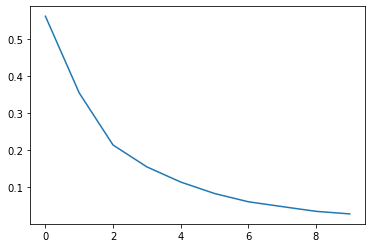

In [81]:
loss_values = history_model.loss_curve_
plt.plot(loss_values)
plt.show()

In [82]:
pred = TextClassifier2.predict(TF_IDF_test)
print(confusion_matrix(YTest,pred))
print(classification_report(YTest,pred))

[[ 458  177]
 [  87 2480]]
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       635
           1       0.93      0.97      0.95      2567

    accuracy                           0.92      3202
   macro avg       0.89      0.84      0.86      3202
weighted avg       0.91      0.92      0.92      3202

